In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/KK assignmet/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


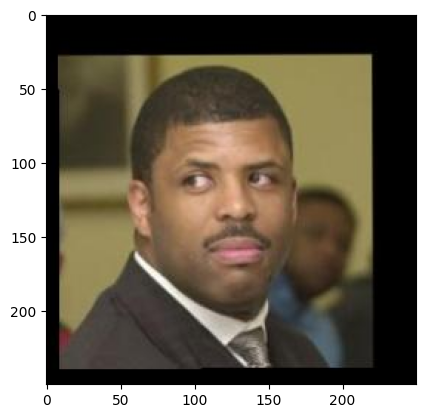

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [7]:
# Step 2: Get a sample from the dataloader and print its dimensions

# Get the first batch from the dataloader
sample_batch, _ = next(iter(dataloader))

# Display the dimensions of the sample
print(f"Sample Dimensions: {sample_batch.shape}")

# Explain each dimension
batch_size, channels, height, width = sample_batch.shape
print(f"Batch Size: {batch_size}")
print(f"Number of Channels: {channels}")
print(f"Image Height: {height}")
print(f"Image Width: {width}")

Sample Dimensions: torch.Size([32, 3, 250, 250])
Batch Size: 32
Number of Channels: 3
Image Height: 250
Image Width: 250


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):  # Fix: Change init to __init__
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(128)

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = F.relu(self.encoder_bn3(self.encoder_conv3(x)))
        return x

    def decoder(self, x):
        # Use a single ConvTranspose2d layer for upsampling
        x = torch.sigmoid(self.decoder_bn1(self.decoder_conv1(x)))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create an instance of the AE model
autoencoder = AE()

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [11]:
# Get a sample from the dataloader
for x, y in dataloader:
    sample_image = x[0]  # Take the first image from the batch as a sample
    break

# Reshape the sample image to include a batch dimension
sample_image = sample_image.unsqueeze(0)

# Convert the sample image to MPSFloatType explicitly
sample_image = sample_image.to(dtype=torch.float32)

# Pass the sample image through the autoencoder
encoded_output = autoencoder.encoder(sample_image)
decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print(f"Shape of Encoder Output: {encoded_output.shape}")
print(f"Shape of Decoder Output: {decoded_output.shape}")

Shape of Encoder Output: torch.Size([1, 128, 32, 32])
Shape of Decoder Output: torch.Size([1, 3, 64, 64])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [12]:
# Calculate the total number of parameters in the autoencoder model
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

Total Number of Parameters: 97161


In [13]:
import torch.nn as nn
import torch.optim as optim

# Your Autoencoder class definition
autoencoder = AE()

# Print total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)  # Adjust learning rate as needed

Total Number of Parameters: 97161


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
from tqdm import tqdm

num_epochs = 5  # You can adjust this value

for epoch in range(num_epochs):
    total_loss = 0.0

    # Create a tqdm progress bar for the training data
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)

    # Training
    for inputs, _ in progress_bar:
        # Move inputs to the MPS device if needed
        inputs = inputs.to(dtype=torch.float32)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)

        # Ensure the output size matches the input size
        outputs = F.interpolate(outputs, size=inputs.shape[2:], mode='bilinear', align_corners=False)

        # Calculate the loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'\nEpoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}')

# Training complete
print('Finished Training')

Epoch 1/5: 100%|██████████| 414/414 [10:59<00:00,  1.59s/it, loss=0.0101]



Epoch [1/5], Average Loss: 0.0164


Epoch 2/5: 100%|██████████| 414/414 [11:15<00:00,  1.63s/it, loss=0.00663]



Epoch [2/5], Average Loss: 0.0075


Epoch 3/5: 100%|██████████| 414/414 [11:21<00:00,  1.65s/it, loss=0.00891]



Epoch [3/5], Average Loss: 0.0055


Epoch 4/5: 100%|██████████| 414/414 [11:24<00:00,  1.65s/it, loss=0.00391]



Epoch [4/5], Average Loss: 0.0047


Epoch 5/5: 100%|██████████| 414/414 [11:46<00:00,  1.71s/it, loss=0.00536]


Epoch [5/5], Average Loss: 0.0044
Finished Training


To troubleshoot a machine learning model when the loss is not decreasing:

1. **Check Data Quality:** Ensure your training data is diverse and representative.
  
2. **Adjust Learning Rate:** Experiment with different learning rates; it might be too high or too low.

3. **Add More Data:** Increase the amount of training data if possible.

4. **Change Model Architecture:** Try a different type of model or adjust its complexity.

5. **Train for Longer:** Allow the model to learn for more epochs.

6. **Debug Code:** Check for errors or bugs in your code.

7. **Evaluate Task Difficulty:** Reassess whether the task is realistically achievable with the given data and model.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

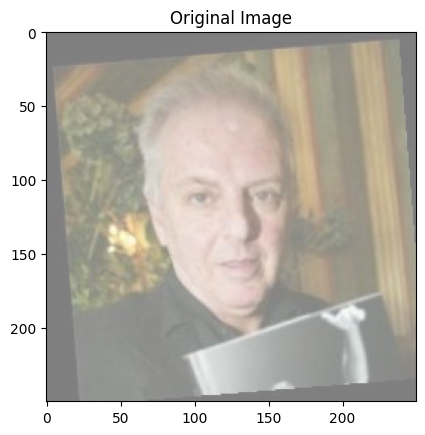

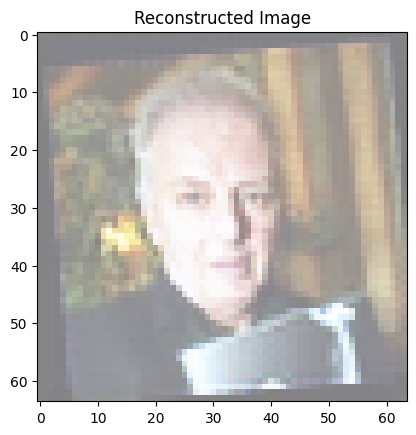

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get a random batch of images from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0].unsqueeze(0)

# Pass the random image through the autoencoder
reconstructed_image = autoencoder(random_image)

# Display the original and reconstructed images
imshow(torchvision.utils.make_grid(random_image), title="Original Image")
imshow(torchvision.utils.make_grid(reconstructed_image.detach()), title="Reconstructed Image")


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

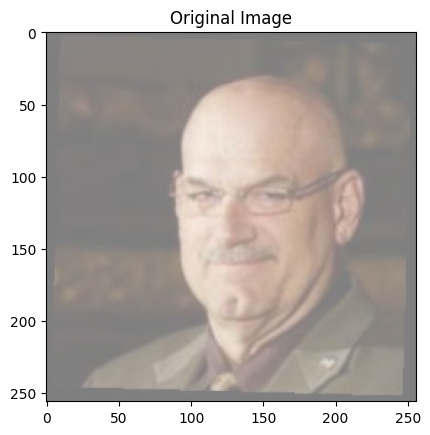

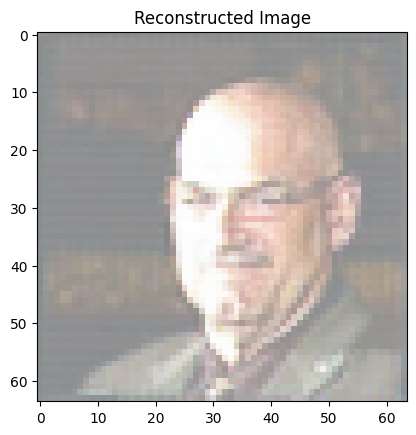

Perturbed Reconstructed Image:


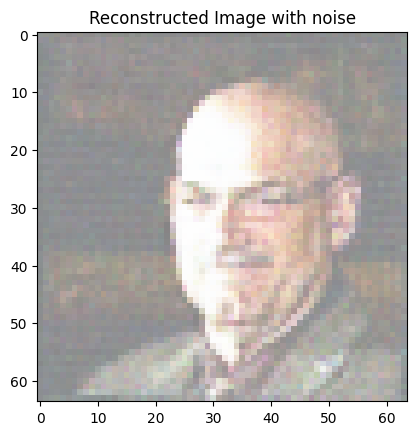

In [21]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

# Your existing code for the autoencoder class

# Load the dataset and create the dataloader
path = 'lfw'
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# Function to add noise to the latent representation
def add_noise(latent_representation, noise_factor=0.2):
    noise = torch.randn_like(latent_representation) * noise_factor
    perturbed_latent = latent_representation + noise
    return perturbed_latent

# Get a random image from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0].unsqueeze(0)

# Pass the random image through the autoencoder
encoded_output = autoencoder.encoder(random_image)
decoded_output = autoencoder.decoder(encoded_output)

# Display the original and reconstructed images
imshow(torchvision.utils.make_grid(random_image), title="Original Image")
imshow(torchvision.utils.make_grid(decoded_output), title="Reconstructed Image")

# Add noise to the latent represent
perturbed_latent = add_noise(encoded_output)
perturbed_decoded_output = autoencoder.decoder(perturbed_latent)

# Display the perturbed reconstructed image
print("Perturbed Reconstructed Image:")
imshow(torchvision.utils.make_grid(perturbed_decoded_output), title="Reconstructed Image with noise")


Adding noise during training in a machine learning model:

1. **Enhances Robustness:** Improves the model's ability to handle noisy real-world data.
  
2. **Acts as Regularization:** Prevents overfitting by introducing noise, promoting better generalization.

3. **Improves Denoising:** Trains the model to remove added noise, useful for tasks like image denoising.

4. **Increases Tolerance:** Makes the model less sensitive to small variations in input, enhancing performance in diverse scenarios.